# Q2: Lets go deeper! CaffeNet for PASCAL classification (20 pts)

**Note:** You are encouraged to reuse code from the previous task. Finish Q1 if you haven't already!


As you might have seen, the performance of the SimpleCNN model was pretty low for PASCAL. This is expected as PASCAL is much more complex than FASHION MNIST, and we need a much beefier model to handle it.

In this task we will be constructing a variant of the [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) architecture, known as CaffeNet. If you are familiar with Caffe, a prototxt of the network is available [here](https://github.com/BVLC/caffe/blob/master/models/bvlc_reference_caffenet/train_val.prototxt). A visualization of the network is available [here](http://ethereon.github.io/netscope/#/preset/caffenet).


## 2.1 Build CaffeNet (5 pts)
Here is the exact model we want to build. In this task, `torchvision.models.xxx()` is NOT allowed. Define your own CaffeNet! We use the following operator notation for the architecture:
1. Convolution: A convolution with kernel size $k$, stride $s$, output channels $n$, padding $p$ is represented as $conv(k, s, n, p)$.
2. Max Pooling: A max pool operation with kernel size $k$, stride $s$ as $maxpool(k, s)$.
3. Fully connected: For $n$ output units, $FC(n)$.
4. ReLU: For rectified linear non-linearity $relu()$

```
ARCHITECTURE:
-> image
-> conv(11, 4, 96, ’VALID’)
-> relu()
-> max_pool(3, 2)
-> conv(5, 1, 256, 'SAME')
-> relu()
-> max_pool(3, 2)
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 256, ’SAME’)
-> relu()
-> max_pool(3, 2)
-> flatten()
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(20)
```

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.utils import load_state_dict_from_url
import os
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset
%env CUDA_VISIBLE_DEVICES=0

%matplotlib inline



class CaffeNet(nn.Module):
    def __init__(self):
        super().__init__()
        conv1 = [nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=0,bias=True)]
                      
        self.conv_first = nn.Sequential(*conv1)
        
        self.conv1_features = [] #epoch,features of filters
        conv_layers = [
                        nn.ReLU(inplace=True),
                       nn.MaxPool2d(kernel_size=3,stride=2),
                       nn.Conv2d(in_channels=96,out_channels=256,stride=1,kernel_size=5,padding=2,bias=True),
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(kernel_size=3,stride=2),
                       
                       nn.Conv2d(in_channels=256,out_channels=384,stride=1,kernel_size=3,padding=1,bias=True),
                       nn.ReLU(inplace=True),
                       
                       nn.Conv2d(in_channels=384,out_channels=384,stride=1,kernel_size=3,padding=1,bias=True),
                       nn.ReLU(inplace=True),
                       
                       nn.Conv2d(in_channels=384,out_channels=256,stride=1,kernel_size=3,padding=1,bias=True),
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(kernel_size=3,stride=2)
                      ]
        self.conv_layers = nn.Sequential(*conv_layers)
        fc = [nn.Linear(256*11*11,4096,bias=True),
             nn.ReLU(inplace=True),
             nn.Dropout(0.5),
             
              nn.Linear(4096,4096,bias=True),
            nn.ReLU(inplace=True),
              nn.Dropout(0.5),
              
              nn.Linear(4096,20,bias=True)
             ]
        self.fc_layers = nn.Sequential(*fc)
#         self.conv_first.register_forward_hook(self.save_outputs_hook())
        
#     def save_outputs_hook(self):
#         def hook(model,inp, output):
#             self.conv1_features.append(output.detach())
#         return hook

    
    
    def forward(self, x):
        x=self.conv_first(x)
        x=self.conv_layers(x)
        x=torch.flatten(x,start_dim=1)
        out=self.fc_layers(x)
        return out

env: CUDA_VISIBLE_DEVICES=0


## 2.2 Save the Model (5 pts)
Finish code stubs for saving the model periodically into `trainer.py`. **You will need these models later**


## 2.3 Train and Test (5pts)
Show clear screenshots of testing MAP and training loss for 50 epochs. Please evaluate your model to calculate the MAP on the testing dataset every 250 iterations. Use the following hyperparamters:
* batch_size=32
* Adam optimizer with lr=0.0001

**NOTE: SAVE AT LEAST 5 EVENLY SPACED CHECKPOINTS DURING TRAINING (1 at end)**

In [3]:
args = ARGS(epochs=50, batch_size=32,test_batch_size=32, lr=0.0001,val_every=250,gamma=0.95,save_freq=5)
model = CaffeNet()
optimizer = torch.optim.Adam(model.parameters(),lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=args.gamma)
test_ap, test_map = trainer.train(args, model, optimizer, scheduler)
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.692977
Test Epoch: 0 [0 (0%)]	mAP: 0.069898
Train Epoch: 0 [100 (64%)]	Loss: 0.261110
Train Epoch: 1 [200 (27%)]	Loss: 0.238920
Test Epoch: 1 [250 (59%)]	mAP: 0.115613
Train Epoch: 1 [300 (91%)]	Loss: 0.238063
Train Epoch: 2 [400 (55%)]	Loss: 0.243902
Train Epoch: 3 [500 (18%)]	Loss: 0.222822
Test Epoch: 3 [500 (18%)]	mAP: 0.155766
Train Epoch: 3 [600 (82%)]	Loss: 0.229039
Train Epoch: 4 [700 (46%)]	Loss: 0.222055
Test Epoch: 4 [750 (78%)]	mAP: 0.169797
Train Epoch: 5 [800 (10%)]	Loss: 0.208249
Train Epoch: 5 [900 (73%)]	Loss: 0.220676
Train Epoch: 6 [1000 (37%)]	Loss: 0.177393
Test Epoch: 6 [1000 (37%)]	mAP: 0.193221
Train Epoch: 7 [1100 (1%)]	Loss: 0.244983
Train Epoch: 7 [1200 (64%)]	Loss: 0.201182
Test Epoch: 7 [1250 (96%)]	mAP: 0.210451
Train Epoch: 8 [1300 (28%)]	Loss: 0.237658
Train Epoch: 8 [1400 (92%)]	Loss: 0.221375
Train Epoch: 9 [1500 (55%)]	Loss: 0.189915
Test Epoch: 9 [1500 (55%)]	mAP: 0.222596
Train Epoch: 10 [1600 (19%)]	Loss: 0.196881
Tr


**INSERT YOUR TENSORBOARD SCREENSHOTS HERE**
<img src="images/train_loss_q2.png">
<img src="images/lr_q2.png">
<img src="images/map_q2_.png">



## 2.4 Visualizing: Conv-1 filters (5pts)
Extract and compare the conv1 filters, at different stages of the training (at least from 3 different iterations). Show at least 5 filters.

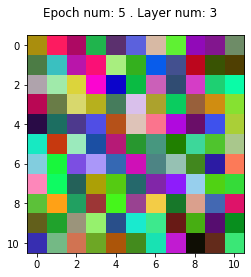

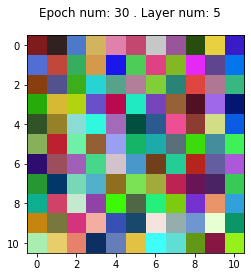

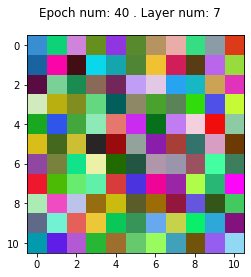

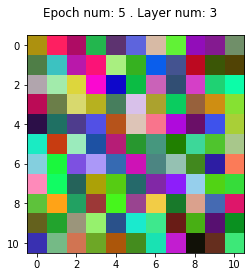

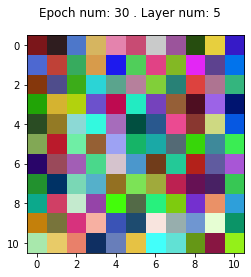

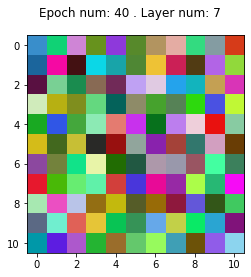

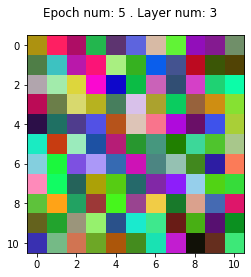

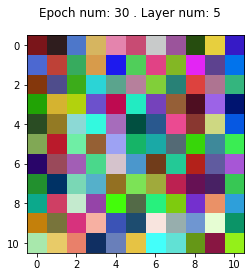

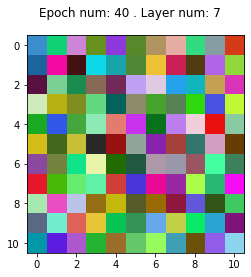

In [48]:
# visualize below
model_weights_5 = torch.load(os.path.join(model.__class__.__name__,"models","5_.pt"))
model_weights_30 = torch.load(os.path.join(model.__class__.__name__,"models","30_.pt"))
model_weights_40 = torch.load(os.path.join(model.__class__.__name__,"models","40_.pt"))
# conv1_weight = chk["model_state_dict"]["conv_first.weight"]
wt_5 = model_weights_5['conv_first.0.weight']
wt_30 = model_weights_30['conv_first.0.weight']
wt_40 = model_weights_40['conv_first.0.weight']
weights = [wt.detach().cpu().numpy() for wt in [wt_5,wt_30,wt_40]]
layer_num = [3,5,7]
epoch_num = [5,30,40]
weights =  [wt[layer_num] for wt in weights] #get wieghts at 3rd 5th and 7th layer
filters_epochs = [weight.transpose(0,2,3,1) for weight in weights]
for filters_epoch in filters_epochs:
    for idx,filter_ in enumerate(filters_epoch):
        plt.figure()
        plt.suptitle('Epoch num: {} . Layer num: {}'.format(epoch_num[idx],layer_num[idx]))
        filter_ = (filter_-filter_.min())/(filter_.max()-filter_.min())
        plt.imshow(filter_)
        plt.show()
        
        
    